In [1]:
import numpy as np
import pandas as pd
import math

from scipy.optimize import minimize, Bounds, fmin_cg
from skopt import gp_minimize
from deap import base, creator, tools, algorithms
import random

from matplotlib import pyplot as plt
import seaborn as sns

import yfinance as yf
import pandas_datareader as pdr
import pandas_market_calendars as mcal

import datetime

# Main idea
1) Exploits Volatility lags behind price movements (due to the rolling nature of variance)
2) Volatility overreacts or underreacts relative to price changes

Arbitrage Opportunity: mispricings caused by lags or overreactions in volatility relative to equity movements.

# Trading logic
We look at the S&P 500(GSPC) and it's volatility index (VIX), calculate the price ratio VIX/GSPC and do a rolling z-scorce.

When volatility lag behind price -> z-scorece become low -> long VIX short GSPC

When volatility over react -> z-scorece become high -> short VIX long GSPC

# Small complication 
Since we cannot directlt trade the index, we need some proxy, such as future or index tracking ETF.

Ideally we would want to use future as:
1) No borrowing fees for short positions
2) Lower transaction costs for larger positions
3) Higher capital efficiency through leverage

We can generate more alpha using future in priciple. However, there are also some extra cost such as
1) Contract Rolling
2) Mismatch between futures expirations

If the future data is not avaliabe, we will use the ETF: VOO and VXX for estimation.

In [45]:
def get_futures_data(start_date, end_date):
    indexes = ['^GSPC', '^VIX']
    
    # Try to download futures data
    try:
        futures = ['ES=F', 'VX=F']
        df = yf.download(indexes + futures, start=start_date, end=end_date)
        
        # Check if we got valid data for VX=F
        if 'VX=F' in df['Close'].columns and not df['Close']['VX=F'].isnull().all():
            close_price = df['Close']
            close_price.columns = [col.replace('^', '') for col in close_price.columns]
            close_price = close_price.rename(columns={'ES=F': 'ES', 'VX=F': 'VX'})
            return close_price
    except:
        pass
    
    # Fallback to ETFs if futures data not available
    etfs = ['VOO', 'VXX']
    df = yf.download(indexes + etfs, start=start_date, end=end_date).dropna()
    close_price = df['Close']
    close_price.columns = [col.replace('^', '') for col in close_price.columns]
    close_price = close_price.rename(columns={'VOO': 'ES', 'VXX': 'VX'})
    
    print("Using ETF data as proxy for futures")
    return close_price


end_date = datetime.date.today()
start_date = end_date - datetime.timedelta(days=3600)
price_data = get_futures_data(start_date, end_date)

[*********************100%***********************]  4 of 4 completed

1 Failed download:
['VX=F']: YFTzMissingError('possibly delisted; no timezone found')
[*********************100%***********************]  4 of 4 completed

Using ETF data as proxy for futures


In [6]:
def Initialize_with_para(price, para):
    lookback_period = para['lookback_period']
    
    returns = price.pct_change().dropna()

    vix_ma = price['VIX'].rolling(window=lookback_period).mean()
    vix_std = price['VIX'].rolling(window=lookback_period).std()
    vix_zscore = (price['VIX'] - vix_ma) / vix_std
    
    vix_spx_ratio = price['VIX'] / price['GSPC']
    vix_spx_ratio_ma = vix_spx_ratio.rolling(window=lookback_period).mean()
    vix_spx_ratio_std = vix_spx_ratio.rolling(window=lookback_period).std()
    vix_spx_ratio_zscore = (vix_spx_ratio - vix_spx_ratio_ma) / vix_spx_ratio_std
    
    return pd.DataFrame({
        'ES': price['ES'],
        'VX': price['VX'],
        'ES_ret': returns['ES'],
        'VX_ret': returns['VX'],
        'VIX_Zscore': vix_zscore,
        'VIX_SPX_ratio_Zscore': vix_spx_ratio_zscore
    })


guess_para = {'lookback_period': 20, 'z_threshold_low':1.1, 'z_threshold_high':3.0, 'position_size':0.5}

data = Initialize_with_para(price_data, guess_para)

In [7]:
def generate_signals(data, para, use_ratio=True):
    z_threshold_low = para['z_threshold_low']
    z_threshold_high = para['z_threshold_high']
    position_size = para['position_size']
    
    df = data.copy()
    
    signal_col = 'VIX_SPX_ratio_Zscore' if use_ratio else 'VIX_Zscore'
    
    df['VX_pos'] = 0.0
    df['ES_pos'] = 0.0
    
    # Long volatility, short equity (Z-score < low threshold)
    df.loc[df[signal_col] < -z_threshold_low, 'VX_pos'] = position_size
    df.loc[df[signal_col] < -z_threshold_low, 'ES_pos'] = -position_size
    
    # Short volatility, long equity (Z-score > high threshold)
    df.loc[df[signal_col] > z_threshold_high, 'VX_pos'] = -position_size
    df.loc[df[signal_col] > z_threshold_high, 'ES_pos'] = position_size
    
    return df

data = generate_signals(data, guess_para)

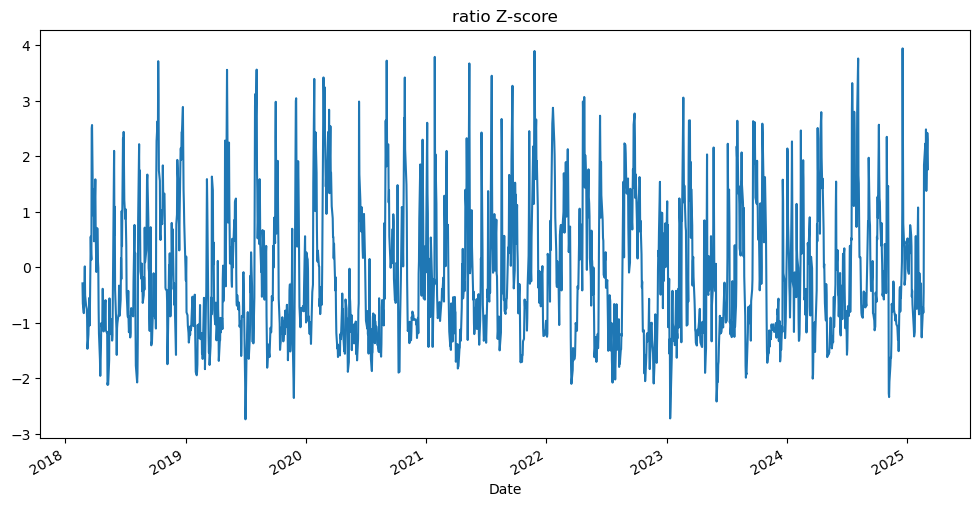

In [8]:
data['VIX_SPX_ratio_Zscore'].plot(title='ratio Z-score',figsize=(12,6))
plt.show()

In [71]:
def backtest(data, initial_capital=100000.0, commission=0.001):
    df = data.copy()
    
    df['capital'] = initial_capital
    df['VX_dollars'] = 0.0
    df['ES_dollars'] = 0.0
    
    if len(df) > 0:
        df.loc[df.index[0], 'VX_dollars'] = df.loc[df.index[0], 'VX_pos'] * initial_capital
        df.loc[df.index[0], 'ES_dollars'] = df.loc[df.index[0], 'ES_pos'] * initial_capital
    
    for i in range(1, len(df)):
        prev_capital = df.loc[df.index[i-1], 'capital']

        # 1-day lag to avoid look-ahead bias
        vx_pnl = df.loc[df.index[i-1], 'VX_dollars'] * df.loc[df.index[i], 'VX_ret']
        es_pnl = df.loc[df.index[i-1], 'ES_dollars'] * df.loc[df.index[i], 'ES_ret']
        
        new_vx_dollars = df.loc[df.index[i], 'VX_pos'] * prev_capital
        new_es_dollars = df.loc[df.index[i], 'ES_pos'] * prev_capital
        
        vx_change = abs(new_vx_dollars - df.loc[df.index[i-1], 'VX_dollars'])
        es_change = abs(new_es_dollars - df.loc[df.index[i-1], 'ES_dollars'])
        commission_cost = (vx_change + es_change) * commission

        daily_pnl = vx_pnl + es_pnl - commission_cost
        df.loc[df.index[i], 'capital'] = prev_capital + daily_pnl
        
        current_capital = df.loc[df.index[i], 'capital']
        df.loc[df.index[i], 'VX_dollars'] = df.loc[df.index[i], 'VX_pos'] * current_capital
        df.loc[df.index[i], 'ES_dollars'] = df.loc[df.index[i], 'ES_pos'] * current_capital
    
    df['daily_pnl'] = df['capital'].diff()
    df['strat_ret'] = df['daily_pnl'] / df['capital'].shift(1)
    
    df['cum_ES_ret'] = (1 + df['ES_ret']).cumprod() - 1
    df['cum_VX_ret'] = (1 + df['VX_ret']).cumprod() - 1
    df['cum_strat_ret'] = (df['capital'] / initial_capital) - 1
    
    df = df.dropna()
    
    return df

# For future trading only (different way of calculating commission)

def backtest_future(data, initial_capital=100000.0, commission_per_contract=2.0, contract_size_es=50, contract_size_vx=1000):
    df = data.copy()
    
    df['capital'] = initial_capital
    
    df['ES_contract_value'] = df['ES'] * contract_size_es
    df['VX_contract_value'] = df['VX'] * contract_size_vx
    
    df['ES_contracts'] = (df['ES_pos'] * df['capital'].shift(1).fillna(initial_capital) / df['ES_contract_value']).round()
    df['VX_contracts'] = (df['VX_pos'] * df['capital'].shift(1).fillna(initial_capital) / df['VX_contract_value']).round()
    
    # 1-day lag to avoid look-ahead bias
    df['ES_dollar_pnl'] = df['ES_contracts'].shift(1) * contract_size_es * df['ES_ret']
    df['VX_dollar_pnl'] = df['VX_contracts'].shift(1) * contract_size_vx * df['VX_ret']
    
    df['ES_contract_change'] = df['ES_contracts'].diff().abs()
    df['VX_contract_change'] = df['VX_contracts'].diff().abs()
    df['commission_dollars'] = (df['ES_contract_change'] + df['VX_contract_change']) * commission_per_contract
    
    df['daily_pnl'] = df['ES_dollar_pnl'] + df['VX_dollar_pnl'] - df['commission_dollars']
    
    for i in range(1, len(df)):
        df.loc[df.index[i], 'capital'] = df.loc[df.index[i-1], 'capital'] + df.loc[df.index[i], 'daily_pnl']
    
    df['strat_ret'] = df['daily_pnl'] / df['capital'].shift(1)
    
    df['cum_ES_ret'] = (1 + df['ES_ret']).cumprod() - 1
    df['cum_VX_ret'] = (1 + df['VX_ret']).cumprod() - 1
    df['cum_strat_ret'] = (df['capital'] / initial_capital) - 1
    
    df = df.dropna()
    
    return df

In [73]:
def calculate_performance(returns):

    if len(returns) == 0:
        return {"Error": "No returns data available"}
        
    total_return = (1 + returns).prod() - 1
    annual_return = (1 + total_return) ** (252 / len(returns)) - 1
    annual_vol = returns.std() * np.sqrt(252)
    sharpe = annual_return / annual_vol if annual_vol != 0 else 0
    
    cum_returns = (1 + returns).cumprod()
    peak = cum_returns.cummax()
    drawdown = (cum_returns / peak) - 1
    max_drawdown = drawdown.min()
    
    mean_return = returns.mean()
    
    return {
        "Total Return": total_return,
        "Annual Return": annual_return,
        "Annual Volatility": annual_vol,
        "Sharpe Ratio": sharpe,
        "Max Drawdown": max_drawdown,
        "Mean Return": mean_return
    }

In [77]:
def optimize_parameters(price_data, lookback_range=(10, 60), 
                        z_threshold_low_range=(-2.0, 1.5),
                        z_threshold_high_range=(1.5, 4.0), 
                        position_size_range=(0.1, 1.0), 
                        target_rfr=0.04, initial_capital=100000.0, 
                        commission=0.001, use_ratio=True):

    best_sharpe = -float('inf')
    best_params = {}
    
    print(f"Optimizing with ranges - Lookback: {lookback_range}, Low threshold: {z_threshold_low_range}, " + 
          f"High threshold: {z_threshold_high_range}, Position size: {position_size_range}")
    
    for lookback in range(lookback_range[0], lookback_range[1] + 1, 5):
        for z_threshold_low in np.arange(z_threshold_low_range[0], z_threshold_low_range[1] + 0.1, 0.2):
            for z_threshold_high in np.arange(z_threshold_high_range[0], z_threshold_high_range[1] + 0.1, 0.3):
                # Skip invalid combinations
                if z_threshold_low > z_threshold_high:
                    continue
                    
                for position_size in np.arange(position_size_range[0], position_size_range[1] + 0.1, 0.1):

                    current_params = {
                        'lookback_period': lookback,
                        'z_threshold_low': z_threshold_low,
                        'z_threshold_high': z_threshold_high,
                        'position_size': position_size
                    }
                    
                    temp_data = Initialize_with_para(price_data, current_params)
                    signals_data = generate_signals(temp_data, current_params, use_ratio)
                    
                    backtest_results = backtest(signals_data, 
                                              initial_capital=initial_capital, 
                                              commission=commission)
                    
                    if len(backtest_results) > 0:
                        returns = backtest_results['strat_ret']
                        
                        if len(returns) == 0 or returns.std() == 0:
                            current_sharpe = -float('inf')
                        else:
                            # Calculate annualized return from final capital
                            final_capital = backtest_results['capital'].iloc[-1]
                            total_return = (final_capital / initial_capital) - 1
                            annual_return = (1 + total_return) ** (252 / len(returns)) - 1
                            
                            # Calculate annualized volatility
                            annual_vol = returns.std() * np.sqrt(252)
                            
                            # Calculate Sharpe ratio
                            current_sharpe = (annual_return - target_rfr) / annual_vol
                        
                        # Update best parameters if needed
                        if current_sharpe > best_sharpe:
                            best_sharpe = current_sharpe
                            best_params = {
                                'lookback_period': lookback,
                                'z_threshold_low': z_threshold_low,
                                'z_threshold_high': z_threshold_high,
                                'position_size': position_size,
                                'sharpe_ratio': current_sharpe
                            }
                            print(f"New best: Lookback={lookback}, " +
                                  f"Z-low={z_threshold_low:.2f}, Z-high={z_threshold_high:.2f}, " +
                                  f"Position={position_size:.2f}, Sharpe={current_sharpe:.4f}")
    
    return best_params


print("\nOptimizing strategy parameters...")
best_params = optimize_parameters(price_data)
print(f"Best parameters found: {best_params}")


Optimizing strategy parameters...
Optimizing with ranges - Lookback: (10, 60), Low threshold: (-2.0, 1.5), High threshold: (1.5, 4.0), Position size: (0.1, 1.0)
New best: Lookback=10, Z-low=-2.00, Z-high=1.50, Position=0.10, Sharpe=-0.8228
New best: Lookback=10, Z-low=-2.00, Z-high=1.50, Position=0.20, Sharpe=-0.6283
New best: Lookback=10, Z-low=-2.00, Z-high=1.50, Position=0.30, Sharpe=-0.5833
New best: Lookback=10, Z-low=-2.00, Z-high=1.50, Position=0.40, Sharpe=-0.5733
New best: Lookback=10, Z-low=-1.40, Z-high=1.50, Position=0.30, Sharpe=-0.5661
New best: Lookback=10, Z-low=-1.40, Z-high=1.50, Position=0.40, Sharpe=-0.5565
New best: Lookback=10, Z-low=1.00, Z-high=1.50, Position=0.30, Sharpe=-0.5288
New best: Lookback=10, Z-low=1.00, Z-high=1.50, Position=0.40, Sharpe=-0.4879
New best: Lookback=10, Z-low=1.00, Z-high=1.50, Position=0.50, Sharpe=-0.4721
New best: Lookback=10, Z-low=1.00, Z-high=1.50, Position=0.60, Sharpe=-0.4685
New best: Lookback=20, Z-low=1.00, Z-high=1.50, Posi

In [78]:
optimized_data = Initialize_with_para(price_data, best_params)
optimized_data = generate_signals(optimized_data, best_params)
optimized_results = backtest(optimized_data)

optimized_performance = calculate_performance(optimized_results['strat_ret'])
print("\nOptimized Performance Metrics:")
for metric, value in optimized_performance.items():
    print(f"{metric}: {value:.2e}")


Optimized Performance Metrics:
Total Return: 6.89e-01
Annual Return: 7.80e-02
Annual Volatility: 2.67e-01
Sharpe Ratio: 2.93e-01
Max Drawdown: -4.53e-01
Mean Return: 4.50e-04


In [79]:
def visualize_strategy(results, params, use_ratio=True):
    plt.figure(figsize=(14, 6))
    plt.plot(results.index, results['cum_strat_ret'], label='Strategy')
    plt.title('Cumulative Returns')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(14, 6))
    signal_col = 'VIX_SPX_ratio_Zscore' if use_ratio else 'VIX_Zscore'
    plt.plot(results.index, results[signal_col], label=signal_col)
    plt.axhline(y=params['z_threshold_high'], color='r', linestyle='--', label='Upper Threshold')
    plt.axhline(y=-params['z_threshold_low'], color='g', linestyle='--', label='Lower Threshold')
    
    long_vx_points = results[results['VX_pos'] > 0].index
    short_vx_points = results[results['VX_pos'] < 0].index
    
    plt.scatter(long_vx_points, results.loc[long_vx_points, signal_col], 
                marker='^', color='green', s=20, label='Long VX/Short ES')
    plt.scatter(short_vx_points, results.loc[short_vx_points, signal_col], 
                marker='v', color='red', s=20, label='Short VX/Long ES')
    
    plt.title(f'{signal_col} with Thresholds')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

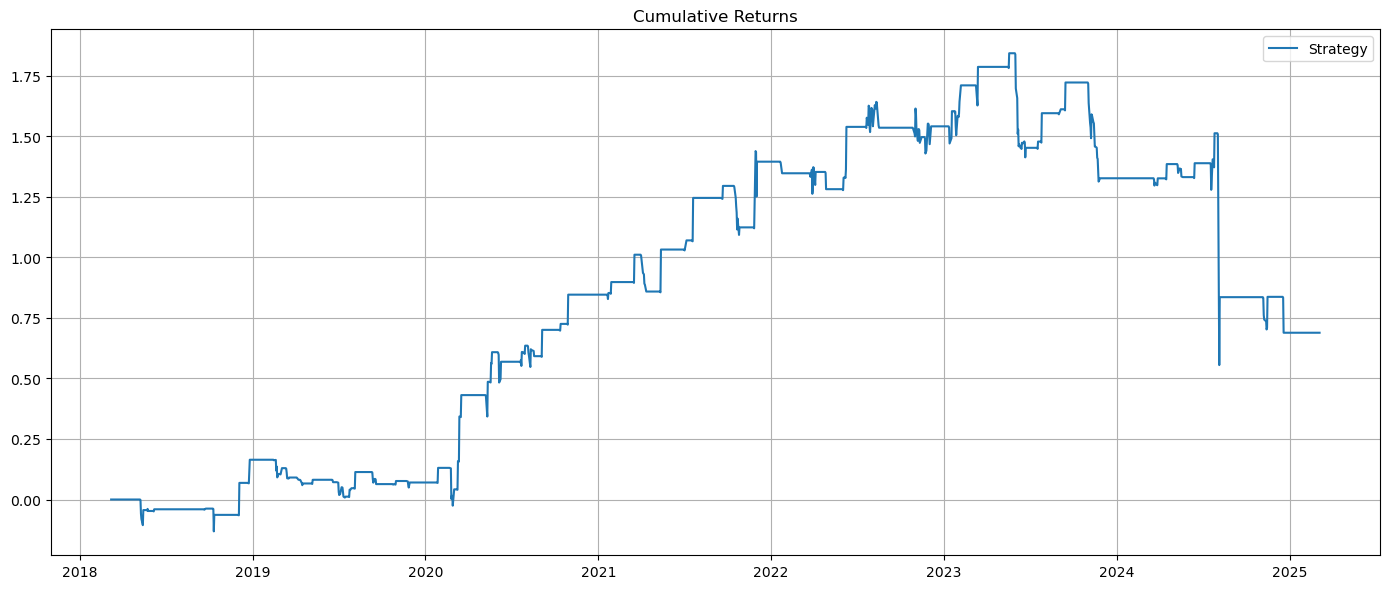

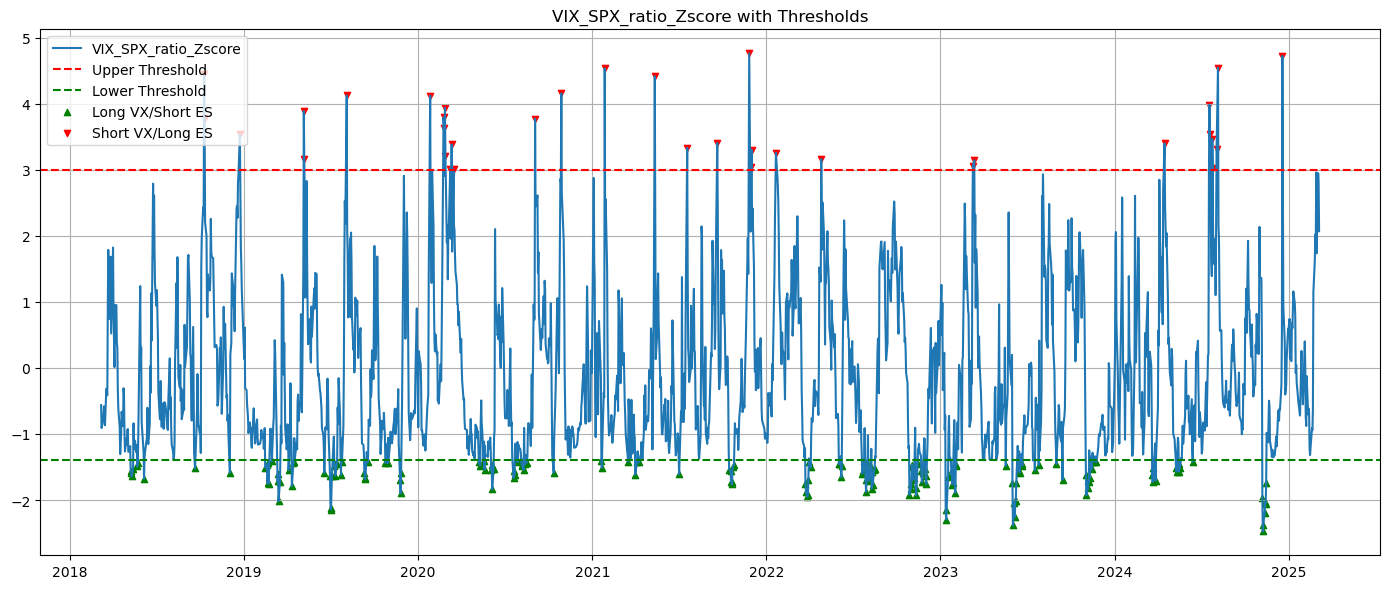

In [80]:
visualize_strategy(optimized_results, best_params)